# Temporal Generalization Decoding
## Use YBN only; linear SVM; feature: NBG activity from all visual electrodes

In [1]:
import os
import scipy.io as sio
import mat73
import numpy as np
from DecodingBasic import DataBasic
from functools import reduce
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

In [2]:
# subject info
sbj_name = 'YBN'
contrast_blk = ['037']
gamma_blk    = ['006']
recall_blk   = ['038', '039', '040']
tone_blk     = ['036']

# home directory
home_path = '~/Documents/MATLAB/ECoG'
home_dir  = os.path.expanduser(home_path)

In [3]:
# initiate decoding data object
train_contrast_obj = DataBasic(sbj_name, contrast_blk,'vis_contrast_only')
train_recall_obj   = DataBasic(sbj_name, recall_blk,'vis_contrast_recall')
train_gamma_obj    = DataBasic(sbj_name, gamma_blk,'vis_contrast_gamma')
test_recall_obj    = DataBasic(sbj_name, recall_blk,'vis_contrast_recall')
test_tone_obj      = DataBasic(sbj_name, tone_blk,'vis_tone_only')

In [4]:
# get electrode list
elec_vis_list  = train_contrast_obj.elec_record('vis') # visual cortex electrodes
elec_resp_list = train_contrast_obj.elec_record('resp') # visual responsive electrodes

## Extract data
Feature matrix: trials * electrodes, element is mean NBG value of a given 50 ms time bin.  
Label vector: contrast level, recoded into 0,1,2.

In [15]:
training_mx3.shape

(225, 52, 500)

In [5]:
# extract training data and testing data, apply normalization
band_NBG, band_BBG = [20, 60], [70, 150]
count_ci = 0 
for ci in elec_resp_list:
    
    # ~~~training data~~~~
    
    # extract spectral data
    train_contrast_spect, label_train_contrast, _ = train_contrast_obj.extract_training_data(ci)    
    train_recall_spect,   label_train_recall, _   = train_recall_obj.extract_training_data(ci)
    train_gamma_spect,    label_train_gamma, _    = train_gamma_obj.extract_training_data(ci)

    # get band averaged value
    train_contrast_NBG = train_contrast_obj.get_band_value(band_NBG, train_contrast_spect, ci)
    train_recall_NBG   = train_recall_obj.get_band_value(band_NBG, train_recall_spect, ci)
    train_gamma_NBG    = train_gamma_obj.get_band_value(band_NBG, train_gamma_spect, ci)
    train_contrast_BBG = train_contrast_obj.get_band_value(band_BBG, train_contrast_spect, ci)
    train_recall_BBG   = train_recall_obj.get_band_value(band_BBG, train_recall_spect, ci)
    train_gamma_BBG    = train_gamma_obj.get_band_value(band_BBG, train_gamma_spect, ci)
    
    # get 5 points value within NBG
    train_contrast_NBG5 = train_contrast_obj.get_NBG_spect(train_contrast_spect, ci)
    train_recall_NBG5   = train_recall_obj.get_NBG_spect(train_recall_spect, ci)
    train_gamma_NBG5    = train_gamma_obj.get_NBG_spect(train_gamma_spect, ci)
    
    # get 11 points value within NBG
    train_contrast_NBG11 = train_contrast_obj.get_NBG_spect(train_contrast_spect, ci, point_num = 11)
    train_recall_NBG11   = train_recall_obj.get_NBG_spect(train_recall_spect, ci, point_num = 11)
    train_gamma_NBG11    = train_gamma_obj.get_NBG_spect(train_gamma_spect, ci, point_num = 11)
    
    # get 9 points value within BBG
    train_contrast_BBG9 = train_contrast_obj.get_BBG_spect(train_contrast_spect, ci)
    train_recall_BBG9   = train_recall_obj.get_BBG_spect(train_recall_spect, ci)
    train_gamma_BBG9    = train_gamma_obj.get_BBG_spect(train_gamma_spect, ci)
    
    # get 21 points value within BBG
    train_contrast_BBG21 = train_contrast_obj.get_BBG_spect(train_contrast_spect, ci, point_num = 21)
    train_recall_BBG21   = train_recall_obj.get_BBG_spect(train_recall_spect, ci, point_num = 21)
    train_gamma_BBG21    = train_gamma_obj.get_BBG_spect(train_gamma_spect, ci, point_num = 21)
    
    # concatenate training data
    training_NBG = np.concatenate((train_contrast_NBG, train_recall_NBG, train_gamma_NBG), axis = 0) 
    training_NBG = training_NBG[:,1000:1500] 
    training_NBG = np.expand_dims(training_NBG, axis = 1)# only mean NBG
    
    training_BBG = np.concatenate((train_contrast_BBG, train_recall_BBG, train_gamma_BBG), axis = 0)
    training_BBG = training_BBG[:,1000:1500] 
    training_BBG = np.expand_dims(training_BBG, axis = 1)# only mean BBG
    
    training_NBG5 = np.concatenate((train_contrast_NBG5, train_recall_NBG5, train_gamma_NBG5), axis = 0)
    training_NBG5 = training_NBG5[:,:,1000:1500]
    
    training_NBG11 = np.concatenate((train_contrast_NBG11, train_recall_NBG11, train_gamma_NBG11), axis = 0)
    training_NBG11 = training_NBG11[:,:,1000:1500]

    training_BBG9 = np.concatenate((train_contrast_BBG9, train_recall_BBG9, train_gamma_BBG9), axis = 0)
    training_BBG9 = training_BBG9[:,:,1000:1500]
    
    training_BBG21 = np.concatenate((train_contrast_BBG21, train_recall_BBG21, train_gamma_BBG21), axis = 0)
    training_BBG21 = training_BBG21[:,:,1000:1500]
    
    # ~~~~testing data~~~~   
    test_recall_spect,    label_test_recall, _    = test_recall_obj.extract_testing_data(ci)
    test_tone_spect,      label_test_tone, _      = test_tone_obj.extract_testing_data(ci)
    
    test_recall_NBG = test_recall_obj.get_band_value(band_NBG, test_recall_spect, ci)
    test_tone_NBG   = test_tone_obj.get_band_value(band_NBG, test_tone_spect, ci)
    test_recall_BBG = test_recall_obj.get_band_value(band_BBG, test_recall_spect, ci)
    test_tone_BBG   = test_tone_obj.get_band_value(band_BBG, test_tone_spect, ci)
    
    test_recall_NBG5 = test_recall_obj.get_NBG_spect(test_recall_spect, ci)
    test_tone_NBG5   = test_tone_obj.get_NBG_spect(test_tone_spect, ci)
    
    test_recall_NBG11 = test_recall_obj.get_NBG_spect(test_recall_spect, ci, point_num = 11)
    test_tone_NBG11   = test_tone_obj.get_NBG_spect(test_tone_spect, ci, point_num = 11)
    
    test_recall_BBG9 = test_recall_obj.get_BBG_spect(test_recall_spect, ci)
    test_tone_BBG9   = test_tone_obj.get_BBG_spect(test_tone_spect, ci)
    
    test_recall_BBG21 = test_recall_obj.get_BBG_spect(test_recall_spect, ci, point_num = 21)
    test_tone_BBG21   = test_tone_obj.get_BBG_spect(test_tone_spect, ci, point_num = 21)
    
    testing_NBG = np.expand_dims(test_recall_NBG[:,1000:4500], axis = 1)
    control_NBG = np.expand_dims(test_tone_NBG[:,1000:4500], axis = 1)

    testing_BBG = np.expand_dims(test_recall_BBG[:,1000:4500], axis = 1)
    control_BBG = np.expand_dims(test_tone_BBG[:,1000:4500], axis = 1)

    testing_NBG5, testing_NBG11 = test_recall_NBG5[:,:,1000:4500], test_recall_NBG11[:,:,1000:4500]
    control_NBG5, control_NBG11 = test_tone_NBG5[:,:,1000:4500],   test_tone_NBG11[:,:,1000:4500]
    testing_BBG9, testing_BBG21 = test_recall_BBG9[:,:,1000:4500], test_recall_BBG21[:,:,1000:4500]
    control_BBG9, control_BBG21 = test_tone_BBG9[:,:,1000:4500],   test_tone_BBG21[:,:,1000:4500]
    
    # ~~~~append data~~~~~    
    if count_ci == 0:
        training_mx1, training_mx2 = training_NBG, training_BBG # NBG only, BBG only
        training_mx3 = np.concatenate((training_NBG, training_BBG), axis = 1) # NBG + BBG
        training_mx4, training_mx5 = training_NBG5, training_BBG9 # 5 points in NBG, 9 points in BBG
        training_mx6 = np.concatenate((training_NBG5, training_BBG9), axis = 1) # 5NBG + 9BBG
        training_mx7, training_mx8 = training_NBG11, training_BBG21 # 11 points in NBG, 21 points in BBF
        training_mx9 = np.concatenate((training_NBG11, training_BBG21), axis = 1) # 11NBG + 21BBG
        
        testing_mx1, testing_mx2 = testing_NBG, testing_BBG
        testing_mx3 = np.concatenate((testing_NBG, testing_BBG), axis = 1)
        testing_mx4, testing_mx5 = testing_NBG5, testing_BBG9
        testing_mx6 = np.concatenate((testing_NBG5, testing_BBG9), axis = 1)
        testing_mx7, testing_mx8 = testing_NBG11, testing_BBG21
        testing_mx9 = np.concatenate((testing_NBG11, testing_BBG21), axis = 1)
        
        control_mx1, control_mx2 = control_NBG, control_BBG
        control_mx3 = np.concatenate((control_NBG, control_BBG), axis = 1)
        control_mx4, control_mx5 = control_NBG5, control_BBG9
        control_mx6 = np.concatenate((control_NBG5, control_BBG9), axis = 1)
        control_mx7, control_mx8 = control_NBG11, control_BBG21
        control_mx9 = np.concatenate((control_NBG11, control_BBG21), axis = 1)
        
    else:
        training_mx1 = np.concatenate((training_mx1, training_NBG), axis = 1)
        training_mx2 = np.concatenate((training_mx2, training_BBG), axis = 1)
        training_mx3 = np.concatenate((training_mx3, training_NBG, training_BBG), axis = 1)
        training_mx4 = np.concatenate((training_mx4, training_NBG5), axis = 1)
        training_mx5 = np.concatenate((training_mx5, training_BBG9), axis = 1)
        training_mx6 = np.concatenate((training_mx6, training_NBG5, training_BBG9), axis = 1)
        training_mx7 = np.concatenate((training_mx7, training_NBG11), axis = 1)
        training_mx8 = np.concatenate((training_mx8, training_BBG21), axis = 1)
        training_mx9 = np.concatenate((training_mx9, training_NBG11, training_BBG21), axis = 1)
        
        testing_mx1 = np.concatenate((testing_mx1, testing_NBG), axis = 1)
        testing_mx2 = np.concatenate((testing_mx2, testing_BBG), axis = 1)
        testing_mx3 = np.concatenate((testing_mx3, testing_NBG, testing_BBG), axis = 1)
        testing_mx4 = np.concatenate((testing_mx4, testing_NBG5), axis = 1)
        testing_mx5 = np.concatenate((testing_mx5, testing_BBG9), axis = 1)
        testing_mx6 = np.concatenate((testing_mx6, testing_NBG5, testing_BBG9), axis = 1)
        testing_mx7 = np.concatenate((testing_mx7, testing_NBG11), axis = 1)
        testing_mx8 = np.concatenate((testing_mx8, testing_BBG21), axis = 1)
        testing_mx9 = np.concatenate((testing_mx9, testing_NBG11, testing_BBG21), axis = 1)
        
        control_mx1 = np.concatenate((control_mx1, control_NBG), axis = 1)
        control_mx2 = np.concatenate((control_mx2, control_BBG), axis = 1)
        control_mx3 = np.concatenate((control_mx3, control_NBG, control_BBG), axis = 1)
        control_mx4 = np.concatenate((control_mx4, control_NBG5), axis = 1)
        control_mx5 = np.concatenate((control_mx5, control_BBG9), axis = 1)
        control_mx6 = np.concatenate((control_mx6, control_NBG5, control_BBG9), axis = 1)
        control_mx7 = np.concatenate((control_mx7, control_NBG11), axis = 1)
        control_mx8 = np.concatenate((control_mx8, control_BBG21), axis = 1)
        control_mx9 = np.concatenate((control_mx9, control_NBG11, control_BBG21), axis = 1)
        
    # ~~~~~extract label~~~~~
    training_label = np.concatenate((label_train_contrast, label_train_recall, label_train_gamma))
    testing_label = label_test_recall
    control_label = label_test_tone
    
    count_ci += 1

In [7]:
# recode label
le = LabelEncoder()
le.fit(training_label)
y_train = le.transform(training_label)
y_test = le.transform(testing_label)
y_control = le.transform(control_label)

## Analysis

In [9]:
def self_decoding(data, y, time_bin = 50, cv_diag = False):
    '''
    Temporal generalization decoding of a given task itself
    
    Returns:
    ACC_mx
    p_mx
    '''
    time_points = data.shape[2]
    bins = time_points//time_bin
    
    # initiate matrices for results storage
    ACC_mx = np.zeros((bins,bins))
    p_mx   = np.zeros((bins,bins))
    
    for i in range(bins):
        for j in range(bins):
            ind_i = i*time_bin 
            ind_j = j*time_bin
            training_mx = np.mean(data[:,:,ind_i:(ind_i+time_bin)], axis = 2)
            testing_mx  = np.mean(data[:,:,ind_j:(ind_j+time_bin)], axis = 2)
            
            if cv_diag and (i==j):
                X = training_mx
                
                cv = StratifiedKFold(3)
                pipe = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='linear'))])
                score, permutation_scores, pvalue = permutation_test_score(pipe, X, y, scoring="accuracy", cv=cv, n_permutations=10, n_jobs=1)
                
                ACC_mx[i,j] = score
                p_mx[i,j] = pvalue
            else:
                
                X_train = training_mx
                X_test = testing_mx
                
                pipe = Pipeline([('scaler', StandardScaler()), 
                                 ('clf', SVC(kernel='linear'))])
                pipe.fit(X_train,y)
                ACC_mx[i,j] = np.mean(pipe.predict(X_test)==y)
    
    return ACC_mx, p_mx

In [10]:
def perc_to_recall(training_data, testing_data, y_train, y_test, time_bin = 50):
    train_bins = 500//time_bin
    test_bins  = 3500//time_bin
    ACC_mx = np.zeros((train_bins, test_bins))
    
    for i in range(train_bins):
        for j in range(test_bins):
            ind_i = time_bin*i
            ind_j = time_bin*j
        
            training_mx = np.mean(training_data[:,:,ind_i:(ind_i+time_bin)], axis = 2)
            testing_mx  = np.mean(testing_data[:,:,ind_j:(ind_j+time_bin)], axis = 2)
            
            pipe = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='linear'))])
            pipe.fit(training_mx, y_train)
            ACC_mx[i,j] = np.mean(pipe.predict(testing_mx)==y_test)
    
    return ACC_mx



### 1. Decoding validation

Classifiers were trained with training data and tested on the training data (training data = data with grating stimulus visually presented) in a temporal manner (time bin = 10ms). 

In [11]:
ACC_vis_NBG, _     = self_decoding(training_mx1,y_train,time_bin=10)
ACC_vis_BBG, _     = self_decoding(training_mx2,y_train,time_bin=10)
ACC_vis_gamma, _   = self_decoding(training_mx3,y_train,time_bin=10)
ACC_vis_NBG5, _    = self_decoding(training_mx4,y_train,time_bin=10)
ACC_vis_BBG9, _    = self_decoding(training_mx5,y_train,time_bin=10)
ACC_vis_gamma10, _ = self_decoding(training_mx6,y_train,time_bin=10)
ACC_vis_NBG11, _   = self_decoding(training_mx7,y_train,time_bin=10)
ACC_vis_BBG21, _   = self_decoding(training_mx8,y_train,time_bin=10)
ACC_vis_gamma4, _  = self_decoding(training_mx9,y_train,time_bin=10)

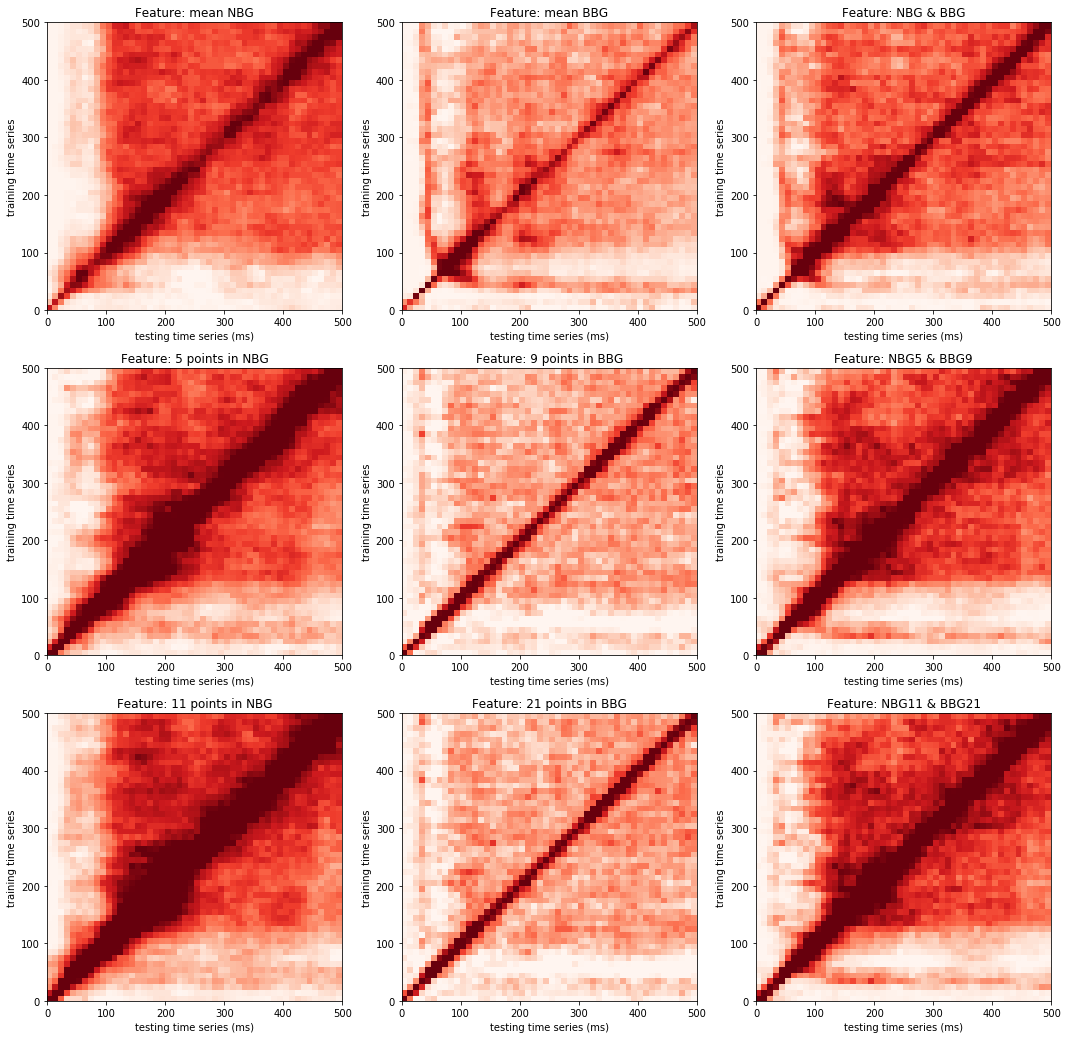

In [32]:
fig, ax = plt.subplots(3,3,figsize = (18,18))
mesh0=ax[0,0].pcolormesh(ACC_vis_NBG, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
mesh1=ax[0,1].pcolormesh(ACC_vis_BBG, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
mesh2=ax[0,2].pcolormesh(ACC_vis_gamma, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
mesh3=ax[1,0].pcolormesh(ACC_vis_NBG5, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
mesh4=ax[1,1].pcolormesh(ACC_vis_BBG9, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
mesh5=ax[1,2].pcolormesh(ACC_vis_gamma10, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
mesh6=ax[2,0].pcolormesh(ACC_vis_NBG11, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
mesh7=ax[2,1].pcolormesh(ACC_vis_BBG21, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
mesh8=ax[2,2].pcolormesh(ACC_vis_gamma4, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
#fig.colorbar(mesh0, ax = ax[0])
#fig.colorbar(mesh1, ax = ax[1])
plt.setp(ax, xticks = np.arange(0,51,10), xticklabels = np.arange(0,501,100),
             yticks = np.arange(0,51,10), yticklabels = np.arange(0,501,100),
             xlabel = 'testing time series (ms)', ylabel = 'training time series');
ax[0,0].set_title('Feature: mean NBG');
ax[0,1].set_title('Feature: mean BBG');
ax[0,2].set_title('Feature: NBG & BBG');
ax[1,0].set_title('Feature: 5 points in NBG');
ax[1,1].set_title('Feature: 9 points in BBG');
ax[1,2].set_title('Feature: NBG5 & BBG9');
ax[2,0].set_title('Feature: 11 points in NBG');
ax[2,1].set_title('Feature: 21 points in BBG');
ax[2,2].set_title('Feature: NBG11 & BBG21');

Validate by shuffling labels

In [16]:
ACC_vis_shuffle1, ACC_vis_shuffle2, ACC_vis_shuffle3, ACC_vis_shuffle4, \
ACC_vis_shuffle5, ACC_vis_shuffle6, ACC_vis_shuffle7, ACC_vis_shuffle8, ACC_vis_shuffle9  \
    = np.zeros((50,50)), np.zeros((50,50)), np.zeros((50,50)), np.zeros((50,50)), np.zeros((50,50)), \
      np.zeros((50,50)), np.zeros((50,50)), np.zeros((50,50)), np.zeros((50,50))

for perm in range(10):
    y_train_shuffle = np.random.permutation(y_train)
    ACC_vis_shuffle1_add, _ = self_decoding(training_mx1, y_train_shuffle, time_bin=10)
    ACC_vis_shuffle2_add, _ = self_decoding(training_mx2, y_train_shuffle, time_bin=10)
    ACC_vis_shuffle3_add, _ = self_decoding(training_mx3, y_train_shuffle, time_bin=10)
    ACC_vis_shuffle4_add, _ = self_decoding(training_mx4, y_train_shuffle, time_bin=10)
    ACC_vis_shuffle5_add, _ = self_decoding(training_mx5, y_train_shuffle, time_bin=10)
    ACC_vis_shuffle6_add, _ = self_decoding(training_mx6, y_train_shuffle, time_bin=10)
    ACC_vis_shuffle7_add, _ = self_decoding(training_mx7, y_train_shuffle, time_bin=10)
    ACC_vis_shuffle8_add, _ = self_decoding(training_mx8, y_train_shuffle, time_bin=10)
    ACC_vis_shuffle9_add, _ = self_decoding(training_mx9, y_train_shuffle, time_bin=10)
    
    ACC_vis_shuffle1 += ACC_vis_shuffle1_add
    ACC_vis_shuffle2 += ACC_vis_shuffle2_add
    ACC_vis_shuffle3 += ACC_vis_shuffle3_add
    ACC_vis_shuffle4 += ACC_vis_shuffle4_add
    ACC_vis_shuffle5 += ACC_vis_shuffle5_add
    ACC_vis_shuffle6 += ACC_vis_shuffle6_add
    ACC_vis_shuffle7 += ACC_vis_shuffle7_add
    ACC_vis_shuffle8 += ACC_vis_shuffle8_add
    ACC_vis_shuffle9 += ACC_vis_shuffle9_add
    
ACC_vis_shuffle1, ACC_vis_shuffle2, ACC_vis_shuffle3, ACC_vis_shuffle4, ACC_vis_shuffle5, \
ACC_vis_shuffle6, ACC_vis_shuffle7, ACC_vis_shuffle8, ACC_vis_shuffle9 \
    = ACC_vis_shuffle1/10, ACC_vis_shuffle2/10, ACC_vis_shuffle3/10, ACC_vis_shuffle4/10, ACC_vis_shuffle5/10, \
      ACC_vis_shuffle6/10, ACC_vis_shuffle7/10, ACC_vis_shuffle8/10, ACC_vis_shuffle9/10

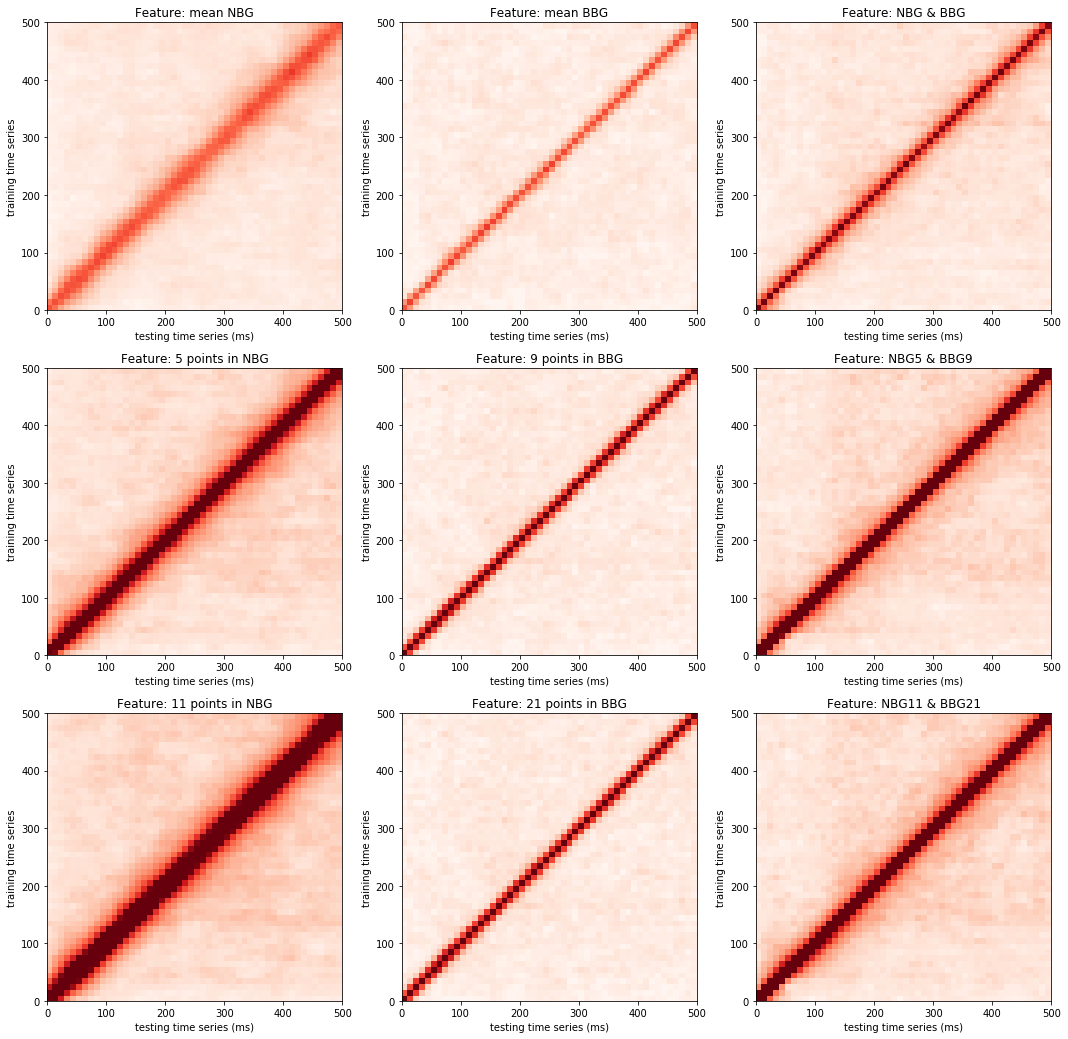

In [33]:
fig, ax = plt.subplots(3,3,figsize = (18,18))
ax[0,0].pcolormesh(ACC_vis_shuffle1, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[0,1].pcolormesh(ACC_vis_shuffle2, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[0,2].pcolormesh(ACC_vis_shuffle3, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[1,0].pcolormesh(ACC_vis_shuffle4, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[1,1].pcolormesh(ACC_vis_shuffle5, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[1,2].pcolormesh(ACC_vis_shuffle6, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[2,0].pcolormesh(ACC_vis_shuffle7, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[2,1].pcolormesh(ACC_vis_shuffle8, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[2,2].pcolormesh(ACC_vis_shuffle9, cmap = 'Reds',vmin = 0.33, vmax = 0.7);

#fig.colorbar(mesh0, ax = ax[0])
#fig.colorbar(mesh1, ax = ax[1])
plt.setp(ax, xticks = np.arange(0,51,10), xticklabels = np.arange(0,501,100),
             yticks = np.arange(0,51,10), yticklabels = np.arange(0,501,100),
             xlabel = 'testing time series (ms)', ylabel = 'training time series');
ax[0,0].set_title('Feature: mean NBG');
ax[0,1].set_title('Feature: mean BBG');
ax[0,2].set_title('Feature: NBG & BBG');
ax[1,0].set_title('Feature: 5 points in NBG');
ax[1,1].set_title('Feature: 9 points in BBG');
ax[1,2].set_title('Feature: NBG5 & BBG9');
ax[2,0].set_title('Feature: 11 points in NBG');
ax[2,1].set_title('Feature: 21 points in BBG');
ax[2,2].set_title('Feature: NBG11 & BBG21');

### 2. Temporal Generalization
2.1: Train on training data and test on testing/control data
In a temporal manner, classifiers were trained on the training data (trials with visually presented grating), and then tested on the delay period of vis_contrast_recall and vis_tone_only, respectively.

In [18]:
ACC_main1 = perc_to_recall(training_mx1,testing_mx1,y_train,y_test,time_bin = 10)
ACC_main2 = perc_to_recall(training_mx2,testing_mx2,y_train,y_test,time_bin = 10)
ACC_main3 = perc_to_recall(training_mx3,testing_mx3,y_train,y_test,time_bin = 10)
ACC_main4 = perc_to_recall(training_mx4,testing_mx4,y_train,y_test,time_bin = 10)
ACC_main5 = perc_to_recall(training_mx5,testing_mx5,y_train,y_test,time_bin = 10)
ACC_main6 = perc_to_recall(training_mx6,testing_mx6,y_train,y_test,time_bin = 10)
ACC_main7 = perc_to_recall(training_mx7,testing_mx7,y_train,y_test,time_bin = 10)
ACC_main8 = perc_to_recall(training_mx8,testing_mx8,y_train,y_test,time_bin = 10)
ACC_main9 = perc_to_recall(training_mx9,testing_mx9,y_train,y_test,time_bin = 10)

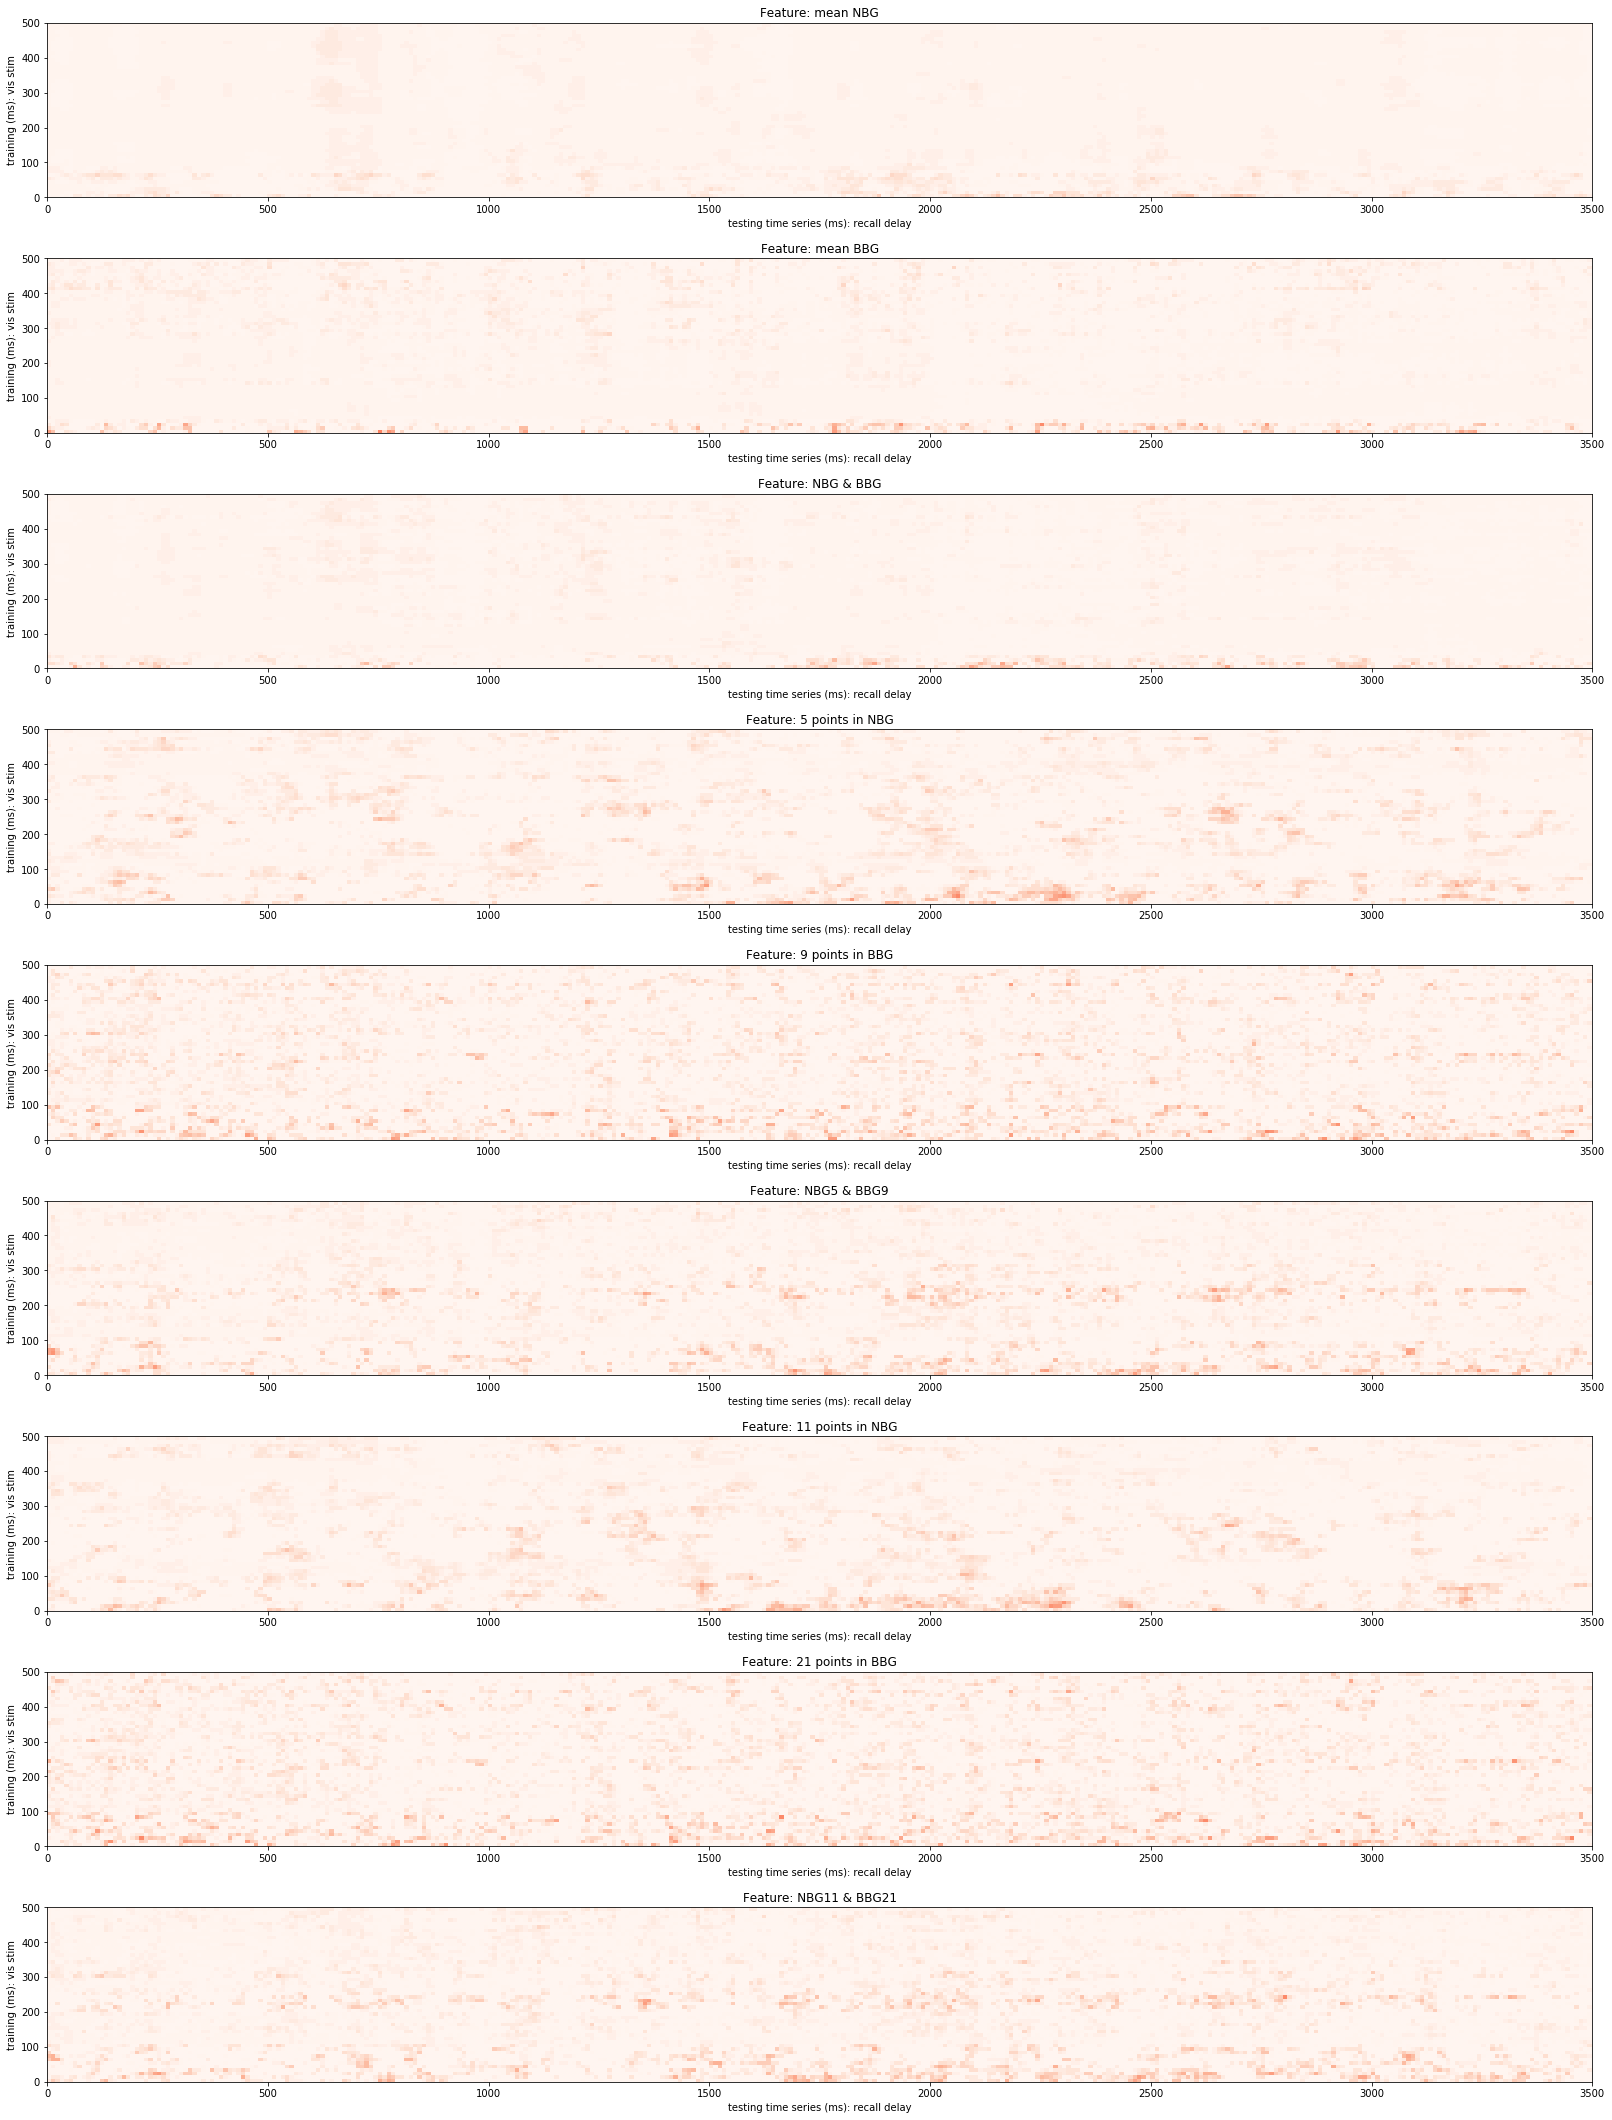

In [34]:
fig, ax = plt.subplots(9,1,figsize = (23,30))
fig.tight_layout(pad=4.0)
ax[0].pcolormesh(ACC_main1, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[1].pcolormesh(ACC_main2, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[2].pcolormesh(ACC_main3, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[3].pcolormesh(ACC_main4, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[4].pcolormesh(ACC_main5, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[5].pcolormesh(ACC_main6, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[6].pcolormesh(ACC_main7, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[7].pcolormesh(ACC_main8, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[8].pcolormesh(ACC_main9, cmap = 'Reds',vmin = 0.33, vmax = 0.7);

#fig.colorbar(im1, ax = ax[0])
#fig.colorbar(im2, ax = ax[1])
plt.setp(ax, xticks = np.arange(0,351,50), xticklabels = np.arange(0,3501,500),
             yticks = np.arange(0,51,10), yticklabels = np.arange(0,501,100),
             xlabel = 'testing time series (ms): recall delay', ylabel = 'training (ms): vis stim');

ax[0].set_title('Feature: mean NBG');
ax[1].set_title('Feature: mean BBG');
ax[2].set_title('Feature: NBG & BBG');
ax[3].set_title('Feature: 5 points in NBG');
ax[4].set_title('Feature: 9 points in BBG');
ax[5].set_title('Feature: NBG5 & BBG9');
ax[6].set_title('Feature: 11 points in NBG');
ax[7].set_title('Feature: 21 points in BBG');
ax[8].set_title('Feature: NBG11 & BBG21');

2.2 Control: tested on tone_only delay

In [21]:
ACC_control1 = perc_to_recall(training_mx1, control_mx1, y_train, y_control, time_bin = 10)
ACC_control2 = perc_to_recall(training_mx2, control_mx2, y_train, y_control, time_bin = 10)
ACC_control3 = perc_to_recall(training_mx3, control_mx3, y_train, y_control, time_bin = 10)
ACC_control4 = perc_to_recall(training_mx4, control_mx4, y_train, y_control, time_bin = 10)
ACC_control5 = perc_to_recall(training_mx5, control_mx5, y_train, y_control, time_bin = 10)
ACC_control6 = perc_to_recall(training_mx6, control_mx6, y_train, y_control, time_bin = 10)
ACC_control7 = perc_to_recall(training_mx7, control_mx7, y_train, y_control, time_bin = 10)
ACC_control8 = perc_to_recall(training_mx8, control_mx8, y_train, y_control, time_bin = 10)
ACC_control9 = perc_to_recall(training_mx9, control_mx9, y_train, y_control, time_bin = 10)

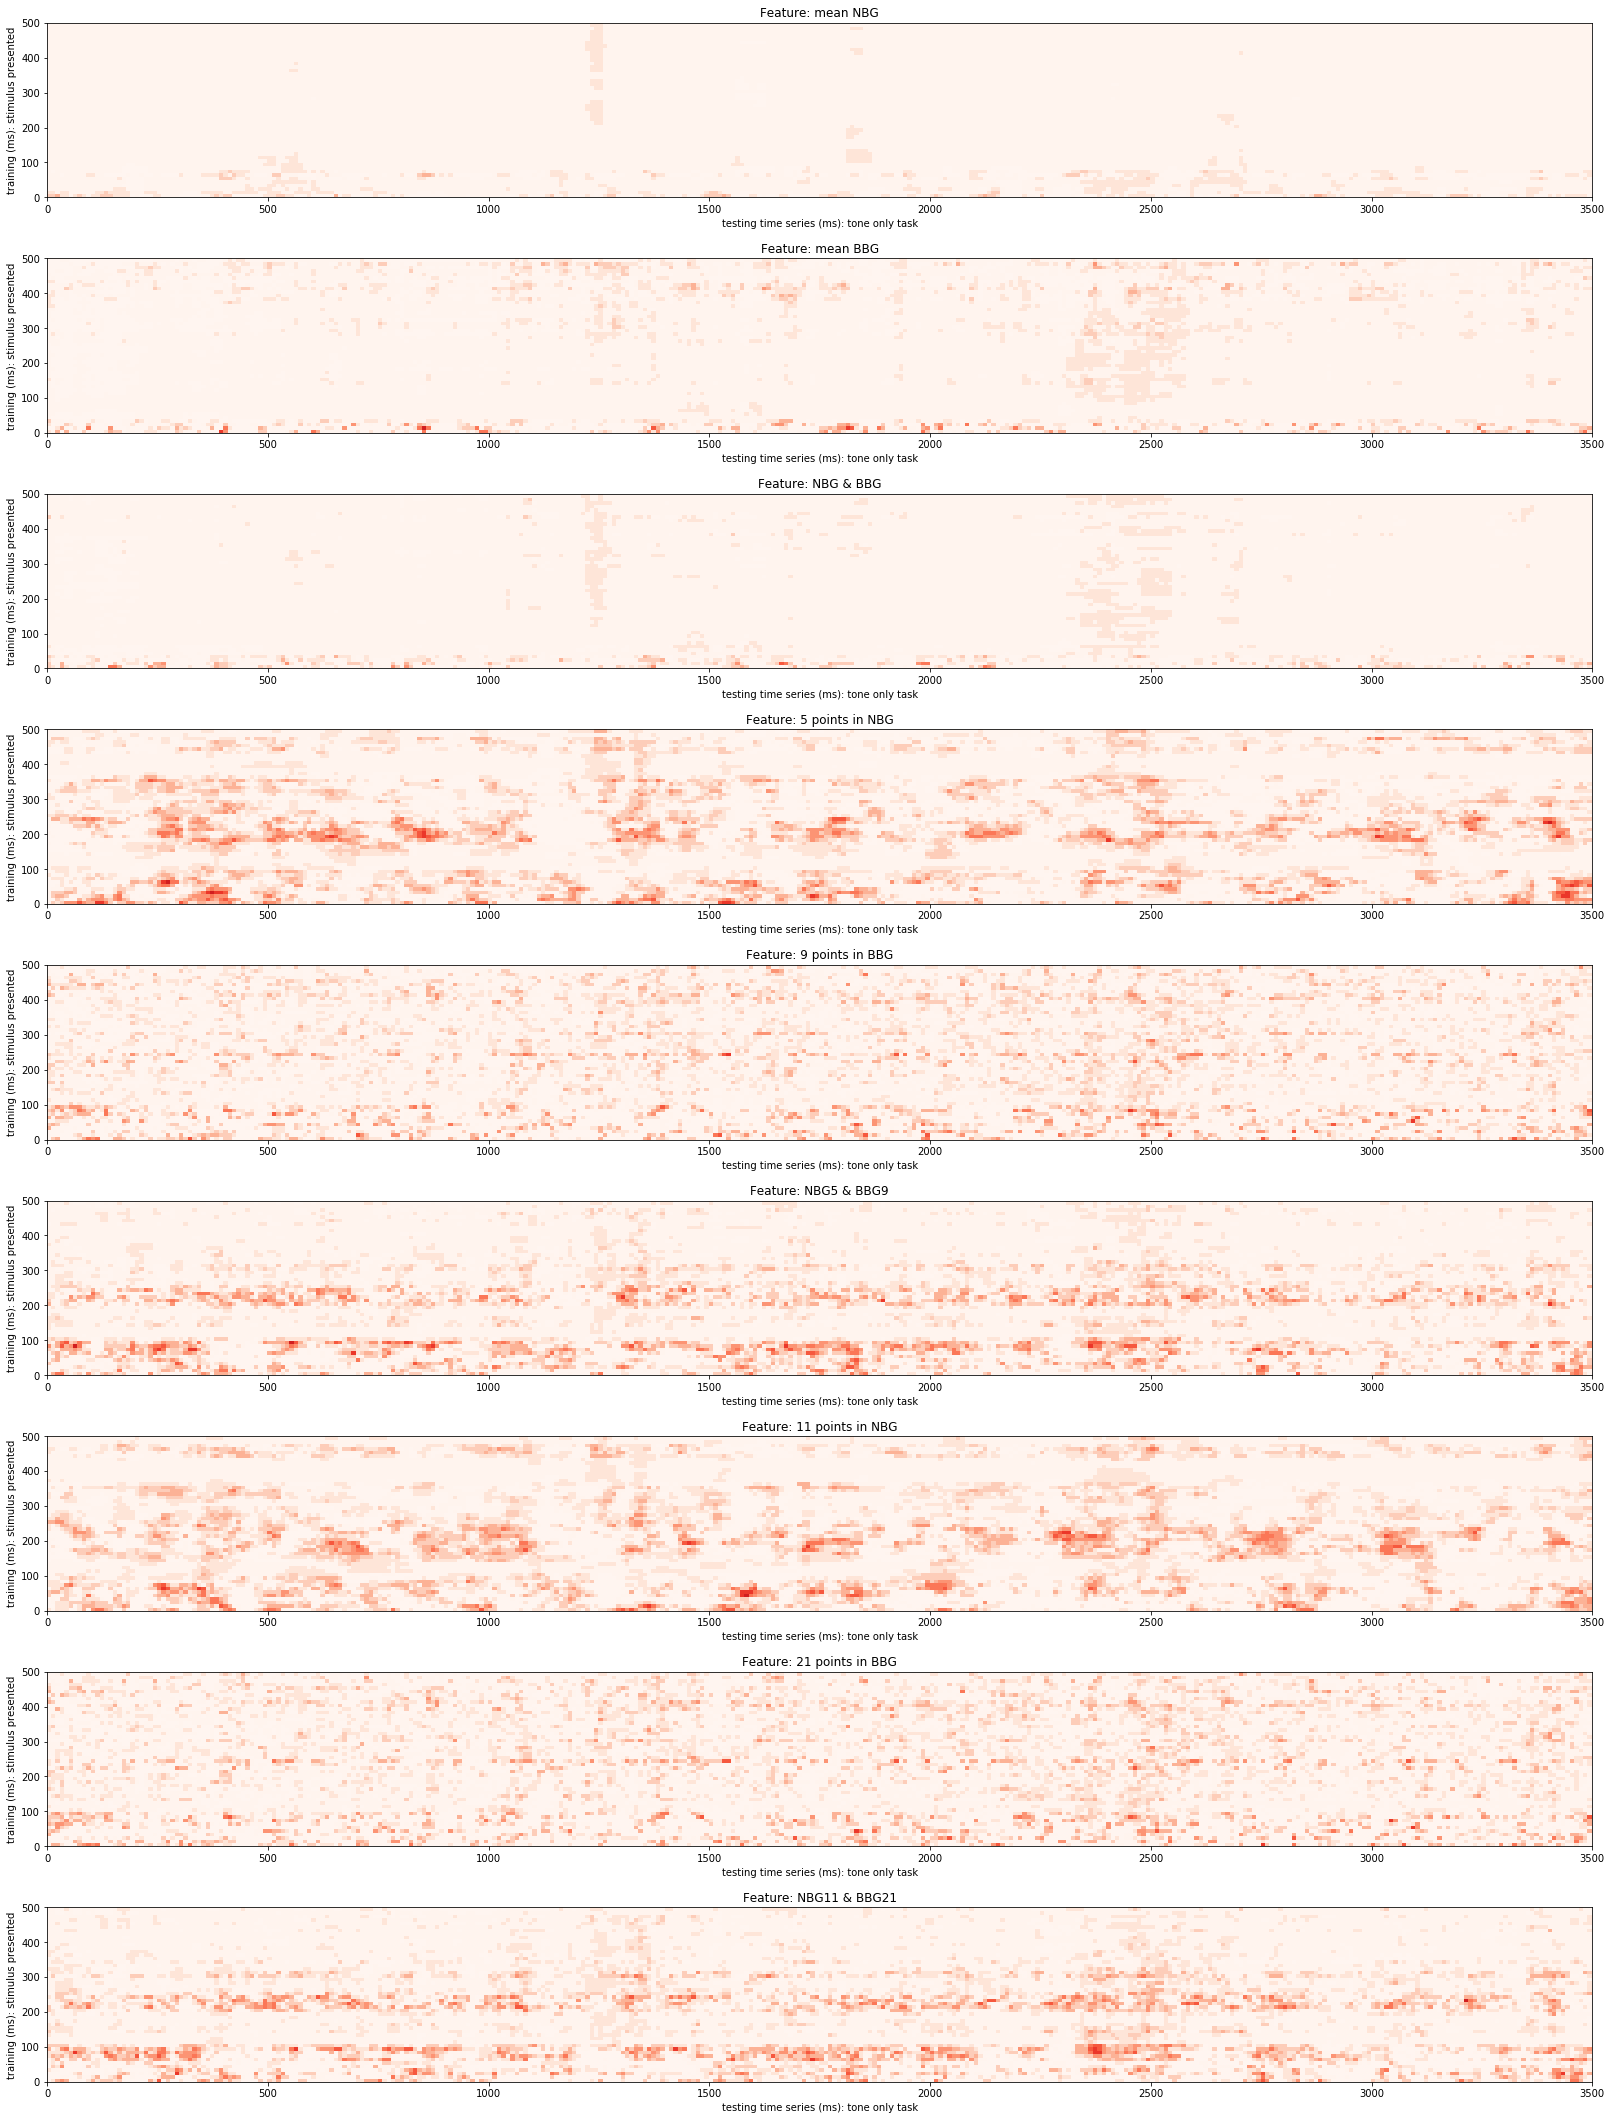

In [35]:
fig, ax = plt.subplots(9,1,figsize = (23,30))
fig.tight_layout(pad=4.0)
ax[0].pcolormesh(ACC_control1, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[1].pcolormesh(ACC_control2, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[2].pcolormesh(ACC_control3, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[3].pcolormesh(ACC_control4, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[4].pcolormesh(ACC_control5, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[5].pcolormesh(ACC_control6, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[6].pcolormesh(ACC_control7, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[7].pcolormesh(ACC_control8, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[8].pcolormesh(ACC_control9, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
#fig.colorbar(im1, ax = ax[0])
#fig.colorbar(im2, ax = ax[1])
plt.setp(ax, xticks = np.arange(0,351,50), xticklabels = np.arange(0,3501,500),
             yticks = np.arange(0,51,10), yticklabels = np.arange(0,501,100),
             xlabel = 'testing time series (ms): tone only task', ylabel = 'training (ms): stimulus presented');

ax[0].set_title('Feature: mean NBG');
ax[1].set_title('Feature: mean BBG');
ax[2].set_title('Feature: NBG & BBG');
ax[3].set_title('Feature: 5 points in NBG');
ax[4].set_title('Feature: 9 points in BBG');
ax[5].set_title('Feature: NBG5 & BBG9');
ax[6].set_title('Feature: 11 points in NBG');
ax[7].set_title('Feature: 21 points in BBG');
ax[8].set_title('Feature: NBG11 & BBG21');

## 3. Self Temporal Generalization
3.1 Recall delay

In [23]:
ACC_recall1, _ = self_decoding(testing_mx1, y_test, time_bin = 50)
ACC_recall2, _ = self_decoding(testing_mx2, y_test, time_bin = 50)
ACC_recall3, _ = self_decoding(testing_mx3, y_test, time_bin = 50)
ACC_recall4, _ = self_decoding(testing_mx4, y_test, time_bin = 50)
ACC_recall5, _ = self_decoding(testing_mx5, y_test, time_bin = 50)
ACC_recall6, _ = self_decoding(testing_mx6, y_test, time_bin = 50)
ACC_recall7, _ = self_decoding(testing_mx7, y_test, time_bin = 50)
ACC_recall8, _ = self_decoding(testing_mx8, y_test, time_bin = 50)
ACC_recall9, _ = self_decoding(testing_mx9, y_test, time_bin = 50)

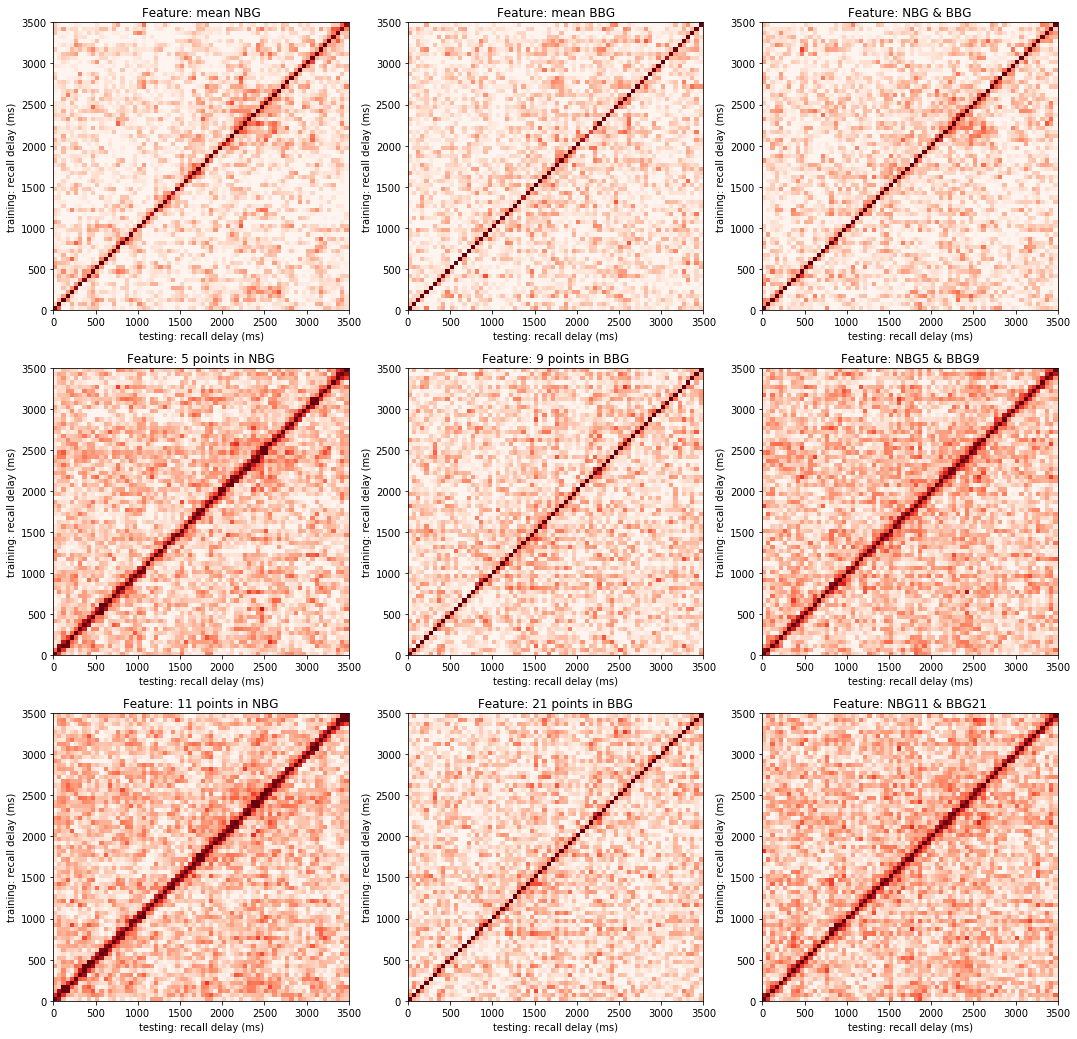

In [36]:
fig, ax = plt.subplots(3,3, figsize = (18,18))

ax[0,0].pcolormesh(ACC_recall1, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[0,1].pcolormesh(ACC_recall2, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[0,2].pcolormesh(ACC_recall3, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[1,0].pcolormesh(ACC_recall4, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[1,1].pcolormesh(ACC_recall5, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[1,2].pcolormesh(ACC_recall6, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[2,0].pcolormesh(ACC_recall7, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[2,1].pcolormesh(ACC_recall8, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[2,2].pcolormesh(ACC_recall9, cmap = 'Reds', vmin = 0.33, vmax = 0.7);

#fig.colorbar(im1, ax = ax[0])
#fig.colorbar(im2, ax = ax[1])
plt.setp(ax, xticks = np.arange(0,71,10), xticklabels = np.arange(0,3601,500),
             yticks = np.arange(0,71,10), yticklabels = np.arange(0,3601,500),
             xlabel = 'testing: recall delay (ms)', ylabel = 'training: recall delay (ms)');

ax[0,0].set_title('Feature: mean NBG');
ax[0,1].set_title('Feature: mean BBG');
ax[0,2].set_title('Feature: NBG & BBG');
ax[1,0].set_title('Feature: 5 points in NBG');
ax[1,1].set_title('Feature: 9 points in BBG');
ax[1,2].set_title('Feature: NBG5 & BBG9');
ax[2,0].set_title('Feature: 11 points in NBG');
ax[2,1].set_title('Feature: 21 points in BBG');
ax[2,2].set_title('Feature: NBG11 & BBG21');

shuffling！

In [26]:
ACC_recall_shuffle1, ACC_recall_shuffle2, ACC_recall_shuffle3, \
ACC_recall_shuffle4, ACC_recall_shuffle5, ACC_recall_shuffle6, \
ACC_recall_shuffle7, ACC_recall_shuffle8, ACC_recall_shuffle9 \
    = np.zeros((70,70)), np.zeros((70,70)), np.zeros((70,70)), np.zeros((70,70)), \
      np.zeros((70,70)), np.zeros((70,70)), np.zeros((70,70)), np.zeros((70,70)), np.zeros((70,70))

for perm in range(10):
    y_test_shuffle = np.random.permutation(y_test)
    ACC_recall_shuffle1_add, _ = self_decoding(testing_mx1, y_test_shuffle, time_bin = 50)
    ACC_recall_shuffle2_add, _ = self_decoding(testing_mx2, y_test_shuffle, time_bin = 50)
    ACC_recall_shuffle3_add, _ = self_decoding(testing_mx3, y_test_shuffle, time_bin = 50)
    ACC_recall_shuffle4_add, _ = self_decoding(testing_mx4, y_test_shuffle, time_bin = 50)
    ACC_recall_shuffle5_add, _ = self_decoding(testing_mx5, y_test_shuffle, time_bin = 50)
    ACC_recall_shuffle6_add, _ = self_decoding(testing_mx6, y_test_shuffle, time_bin = 50)
    ACC_recall_shuffle7_add, _ = self_decoding(testing_mx7, y_test_shuffle, time_bin = 50)
    ACC_recall_shuffle8_add, _ = self_decoding(testing_mx8, y_test_shuffle, time_bin = 50)
    ACC_recall_shuffle9_add, _ = self_decoding(testing_mx9, y_test_shuffle, time_bin = 50)
    
    ACC_recall_shuffle1 += ACC_recall_shuffle1_add
    ACC_recall_shuffle2 += ACC_recall_shuffle2_add
    ACC_recall_shuffle3 += ACC_recall_shuffle3_add
    ACC_recall_shuffle4 += ACC_recall_shuffle4_add
    ACC_recall_shuffle5 += ACC_recall_shuffle5_add
    ACC_recall_shuffle6 += ACC_recall_shuffle6_add
    ACC_recall_shuffle7 += ACC_recall_shuffle7_add
    ACC_recall_shuffle8 += ACC_recall_shuffle8_add
    ACC_recall_shuffle9 += ACC_recall_shuffle9_add

ACC_recall_shuffle1, ACC_recall_shuffle2, ACC_recall_shuffle3, \
ACC_recall_shuffle4, ACC_recall_shuffle5, ACC_recall_shuffle6, \
ACC_recall_shuffle7, ACC_recall_shuffle8, ACC_recall_shuffle9 \
    = ACC_recall_shuffle1/10, ACC_recall_shuffle2/10, ACC_recall_shuffle3/10, \
      ACC_recall_shuffle4/10, ACC_recall_shuffle5/10, ACC_recall_shuffle6/10, \
      ACC_recall_shuffle7/10, ACC_recall_shuffle8/10, ACC_recall_shuffle9/10

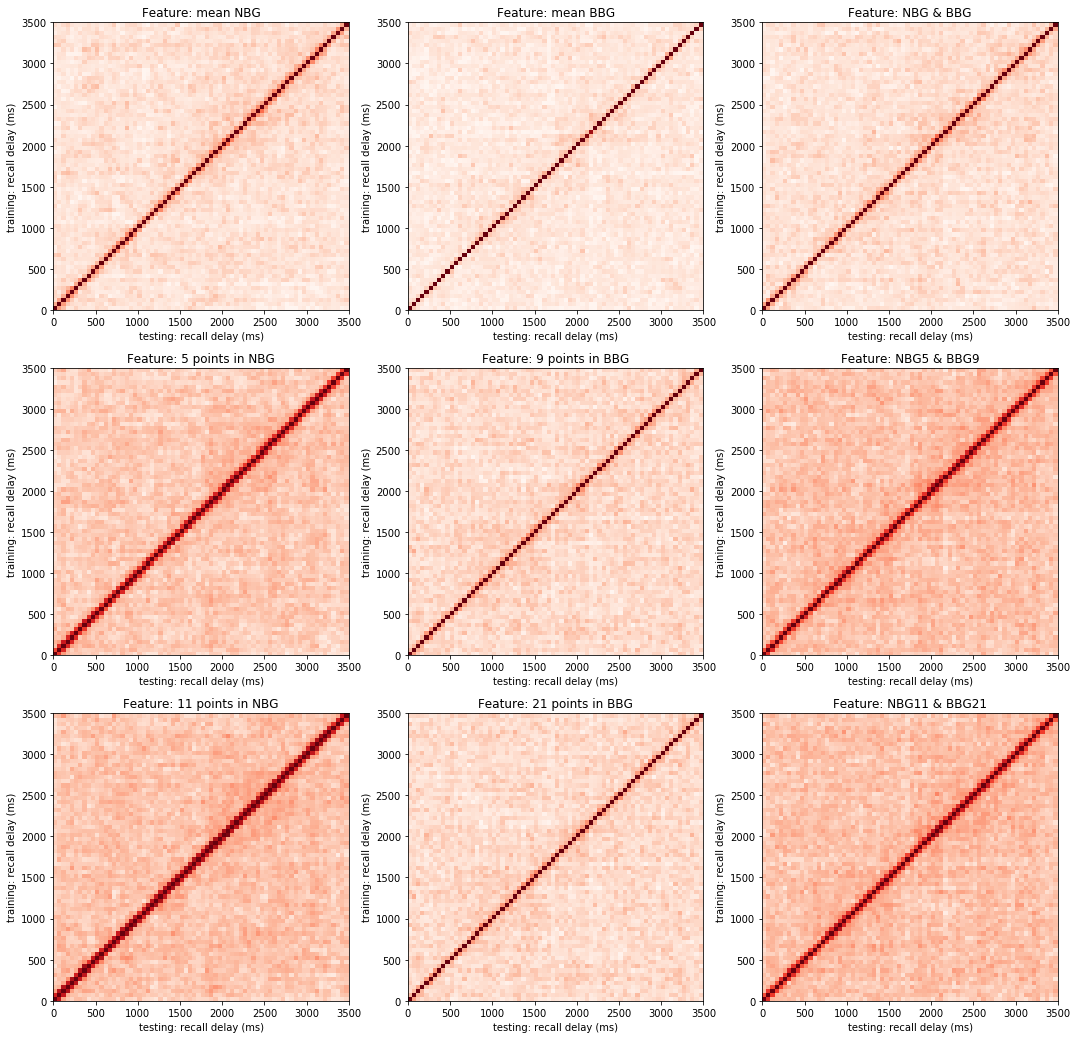

In [37]:
fig, ax = plt.subplots(3,3, figsize = (18,18))

ax[0,0].pcolormesh(ACC_recall_shuffle1, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[0,1].pcolormesh(ACC_recall_shuffle2, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[0,2].pcolormesh(ACC_recall_shuffle3, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[1,0].pcolormesh(ACC_recall_shuffle4, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[1,1].pcolormesh(ACC_recall_shuffle5, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[1,2].pcolormesh(ACC_recall_shuffle6, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[2,0].pcolormesh(ACC_recall_shuffle7, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[2,1].pcolormesh(ACC_recall_shuffle8, cmap = 'Reds', vmin = 0.33, vmax = 0.7);
ax[2,2].pcolormesh(ACC_recall_shuffle9, cmap = 'Reds', vmin = 0.33, vmax = 0.7);

#fig.colorbar(im1, ax = ax[0])
#fig.colorbar(im2, ax = ax[1])
plt.setp(ax, xticks = np.arange(0,71,10), xticklabels = np.arange(0,3601,500),
             yticks = np.arange(0,71,10), yticklabels = np.arange(0,3601,500),
             xlabel = 'testing: recall delay (ms)', ylabel = 'training: recall delay (ms)');

ax[0,0].set_title('Feature: mean NBG');
ax[0,1].set_title('Feature: mean BBG');
ax[0,2].set_title('Feature: NBG & BBG');
ax[1,0].set_title('Feature: 5 points in NBG');
ax[1,1].set_title('Feature: 9 points in BBG');
ax[1,2].set_title('Feature: NBG5 & BBG9');
ax[2,0].set_title('Feature: 11 points in NBG');
ax[2,1].set_title('Feature: 21 points in BBG');
ax[2,2].set_title('Feature: NBG11 & BBG21');

3.2 Control delay

In [28]:
ACC_tone1, _ = self_decoding(control_mx1, y_control, time_bin = 50)
ACC_tone2, _ = self_decoding(control_mx2, y_control, time_bin = 50)
ACC_tone3, _ = self_decoding(control_mx3, y_control, time_bin = 50)
ACC_tone4, _ = self_decoding(control_mx4, y_control, time_bin = 50)
ACC_tone5, _ = self_decoding(control_mx5, y_control, time_bin = 50)
ACC_tone6, _ = self_decoding(control_mx6, y_control, time_bin = 50)
ACC_tone7, _ = self_decoding(control_mx7, y_control, time_bin = 50)
ACC_tone8, _ = self_decoding(control_mx8, y_control, time_bin = 50)
ACC_tone9, _ = self_decoding(control_mx9, y_control, time_bin = 50)

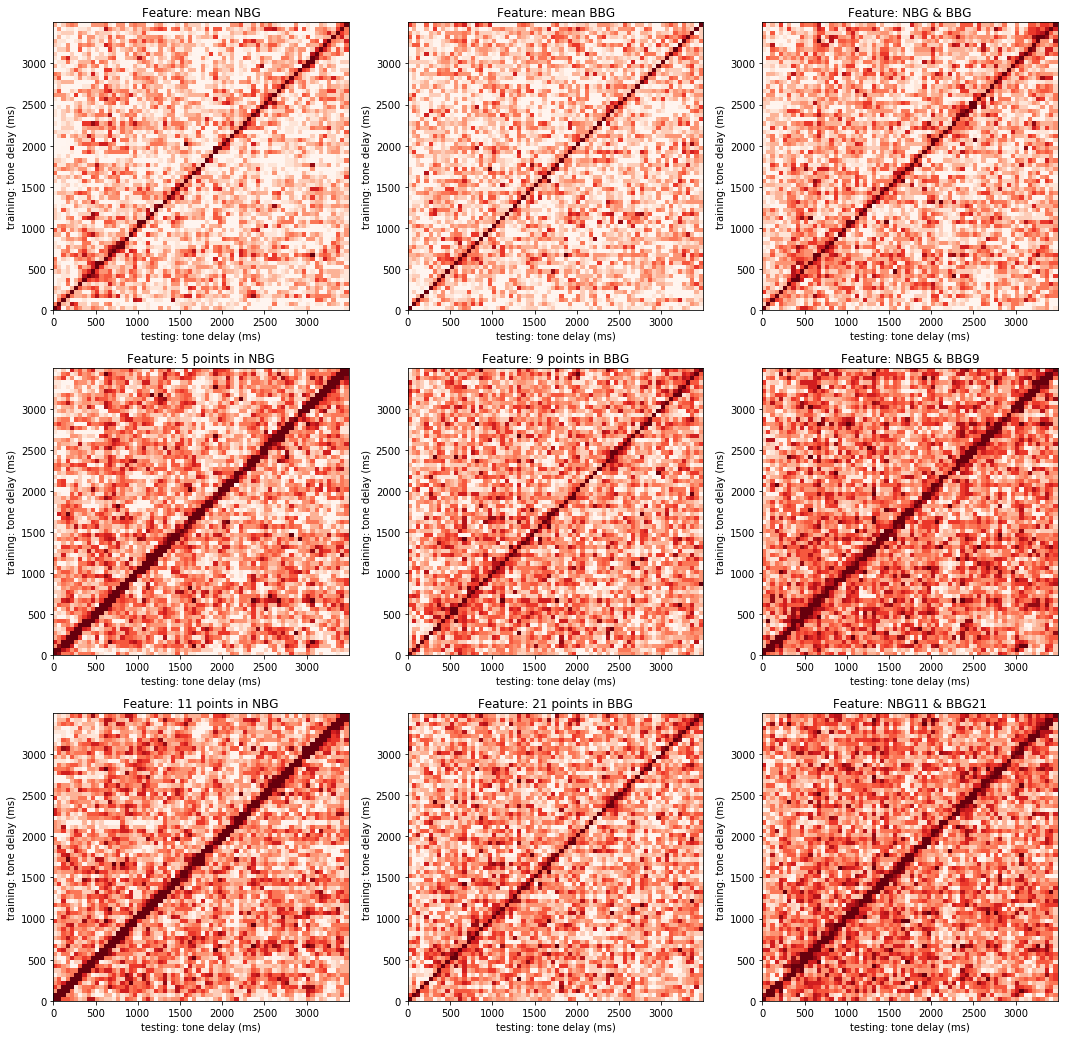

In [38]:
fig, ax = plt.subplots(3,3, figsize = (18,18))

ax[0,0].pcolormesh(ACC_tone1, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[0,1].pcolormesh(ACC_tone2, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[0,2].pcolormesh(ACC_tone3, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[1,0].pcolormesh(ACC_tone4, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[1,1].pcolormesh(ACC_tone5, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[1,2].pcolormesh(ACC_tone6, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[2,0].pcolormesh(ACC_tone7, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[2,1].pcolormesh(ACC_tone8, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[2,2].pcolormesh(ACC_tone9, cmap = 'Reds',vmin = 0.33, vmax = 0.7);

#fig.colorbar(im1, ax = ax[0])
#fig.colorbar(im2, ax = ax[1])
plt.setp(ax, xticks = np.arange(0,61,10), xticklabels = np.arange(0,3601,500),
             yticks = np.arange(0,61,10), yticklabels = np.arange(0,3601,500),
             xlabel = 'testing: tone delay (ms)', ylabel = 'training: tone delay (ms)');

ax[0,0].set_title('Feature: mean NBG');
ax[0,1].set_title('Feature: mean BBG');
ax[0,2].set_title('Feature: NBG & BBG');
ax[1,0].set_title('Feature: 5 points in NBG');
ax[1,1].set_title('Feature: 9 points in BBG');
ax[1,2].set_title('Feature: NBG5 & BBG9');
ax[2,0].set_title('Feature: 11 points in NBG');
ax[2,1].set_title('Feature: 21 points in BBG');
ax[2,2].set_title('Feature: NBG11 & BBG21');

shuffling！


In [30]:
ACC_control_shuffle1, ACC_control_shuffle2,  ACC_control_shuffle3, \
ACC_control_shuffle4, ACC_control_shuffle5,  ACC_control_shuffle6, \
ACC_control_shuffle7, ACC_control_shuffle8,  ACC_control_shuffle9 \
     = np.zeros((70,70)), np.zeros((70,70)), np.zeros((70,70)), np.zeros((70,70)), \
       np.zeros((70,70)), np.zeros((70,70)), np.zeros((70,70)), np.zeros((70,70)), np.zeros((70,70))

for perm in range(10):
    y_control_shuffle = np.random.permutation(y_control)
    ACC_control_shuffle1_add, _ = self_decoding(control_mx1, y_control_shuffle, time_bin = 50)
    ACC_control_shuffle2_add, _ = self_decoding(control_mx2, y_control_shuffle, time_bin = 50)
    ACC_control_shuffle3_add, _ = self_decoding(control_mx3, y_control_shuffle, time_bin = 50)
    ACC_control_shuffle4_add, _ = self_decoding(control_mx4, y_control_shuffle, time_bin = 50)
    ACC_control_shuffle5_add, _ = self_decoding(control_mx5, y_control_shuffle, time_bin = 50)
    ACC_control_shuffle6_add, _ = self_decoding(control_mx6, y_control_shuffle, time_bin = 50)
    ACC_control_shuffle7_add, _ = self_decoding(control_mx7, y_control_shuffle, time_bin = 50)
    ACC_control_shuffle8_add, _ = self_decoding(control_mx8, y_control_shuffle, time_bin = 50)
    ACC_control_shuffle9_add, _ = self_decoding(control_mx9, y_control_shuffle, time_bin = 50)
    
    ACC_control_shuffle1 += ACC_control_shuffle1_add
    ACC_control_shuffle2 += ACC_control_shuffle2_add
    ACC_control_shuffle3 += ACC_control_shuffle3_add
    ACC_control_shuffle4 += ACC_control_shuffle4_add
    ACC_control_shuffle5 += ACC_control_shuffle5_add
    ACC_control_shuffle6 += ACC_control_shuffle6_add
    ACC_control_shuffle7 += ACC_control_shuffle7_add
    ACC_control_shuffle8 += ACC_control_shuffle8_add
    ACC_control_shuffle9 += ACC_control_shuffle9_add
    
ACC_control_shuffle1, ACC_control_shuffle2,  ACC_control_shuffle3, \
ACC_control_shuffle4, ACC_control_shuffle5,  ACC_control_shuffle6, \
ACC_control_shuffle7, ACC_control_shuffle8,  ACC_control_shuffle9 \
     = ACC_control_shuffle1/10, ACC_control_shuffle2/10,  ACC_control_shuffle3/10, \
       ACC_control_shuffle4/10, ACC_control_shuffle5/10,  ACC_control_shuffle6/10, \
       ACC_control_shuffle7/10, ACC_control_shuffle8/10,  ACC_control_shuffle9/10

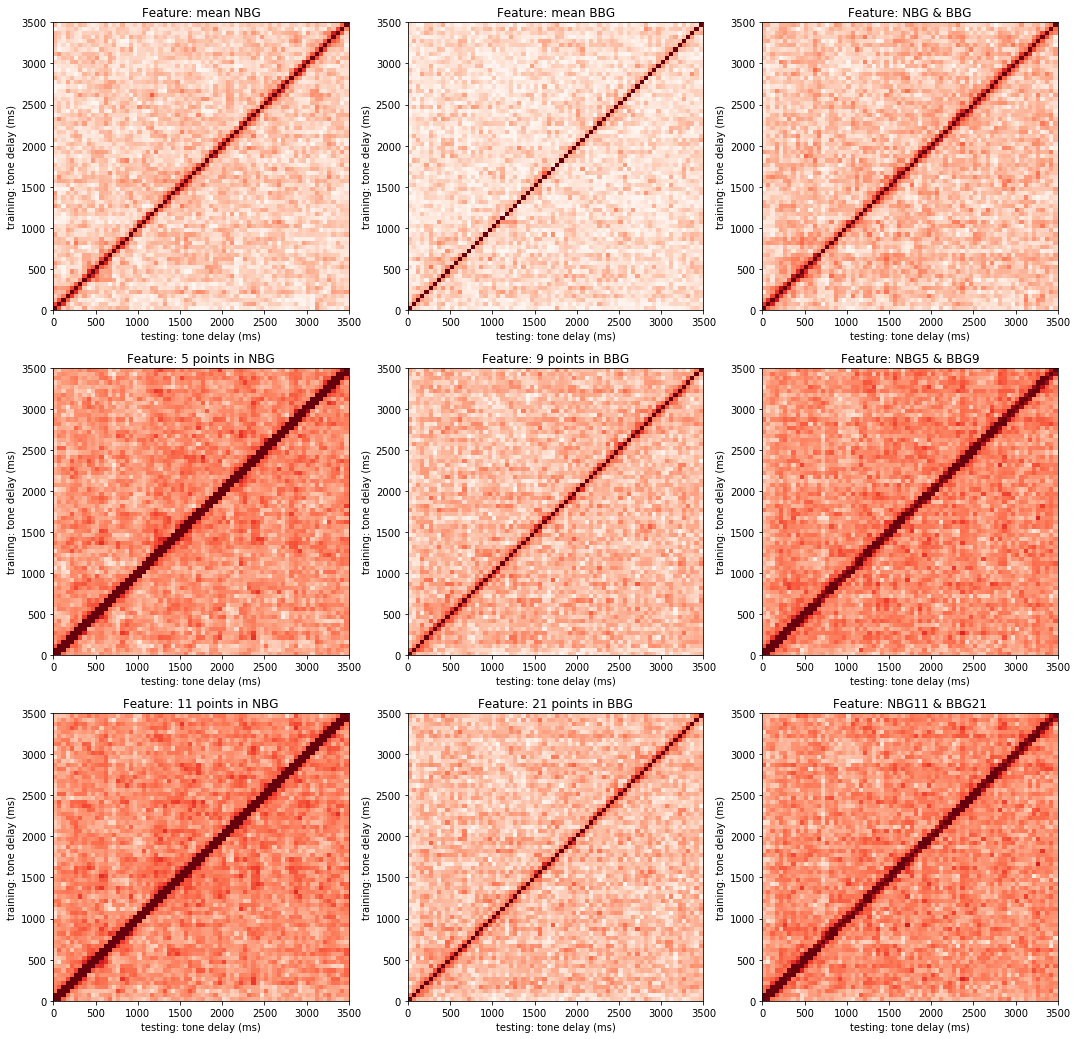

In [39]:
fig, ax = plt.subplots(3,3, figsize = (18,18))

ax[0,0].pcolormesh(ACC_control_shuffle1, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[0,1].pcolormesh(ACC_control_shuffle2, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[0,2].pcolormesh(ACC_control_shuffle3, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[1,0].pcolormesh(ACC_control_shuffle4, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[1,1].pcolormesh(ACC_control_shuffle5, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[1,2].pcolormesh(ACC_control_shuffle6, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[2,0].pcolormesh(ACC_control_shuffle7, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[2,1].pcolormesh(ACC_control_shuffle8, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
ax[2,2].pcolormesh(ACC_control_shuffle9, cmap = 'Reds',vmin = 0.33, vmax = 0.7);
#fig.colorbar(im1, ax = ax[0])
#fig.colorbar(im2, ax = ax[1])
plt.setp(ax, xticks = np.arange(0,71,10), xticklabels = np.arange(0,3601,500),
             yticks = np.arange(0,71,10), yticklabels = np.arange(0,3601,500),
             xlabel = 'testing: tone delay (ms)', ylabel = 'training: tone delay (ms)');

ax[0,0].set_title('Feature: mean NBG');
ax[0,1].set_title('Feature: mean BBG');
ax[0,2].set_title('Feature: NBG & BBG');
ax[1,0].set_title('Feature: 5 points in NBG');
ax[1,1].set_title('Feature: 9 points in BBG');
ax[1,2].set_title('Feature: NBG5 & BBG9');
ax[2,0].set_title('Feature: 11 points in NBG');
ax[2,1].set_title('Feature: 21 points in BBG');
ax[2,2].set_title('Feature: NBG11 & BBG21');